# Extracting a pore network using PoreSpy and loading into OpenPNM


In [1]:
import porespy as ps
import openpnm as op
import scipy as sp
import scipy.ndimage as spim
import matplotlib.pyplot as plt
ws = op.Workspace()
ws.settings['loglevel'] = 50

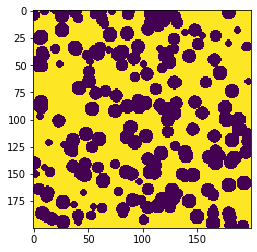

In [2]:
sp.random.seed(0)
im = ps.generators.overlapping_spheres(shape=[200, 200, 200], radius=7, porosity=0.5, iter_max=0)
fig = plt.imshow(im[:, :, 50])

In [3]:
snow = ps.networks.snow(im=im, boundary_faces=['right'])

____________________________________________________________
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1599
Peaks after trimming saddle points:  839
Peaks after trimming nearby peaks:  836
____________________________________________________________
Extracting pore and throat information from image


100%|███████████████████████████████████████████████████████████████████████████████| 917/917 [00:08<00:00, 111.44it/s]


In [4]:
net = op.network.GenericNetwork()
net.update(snow)

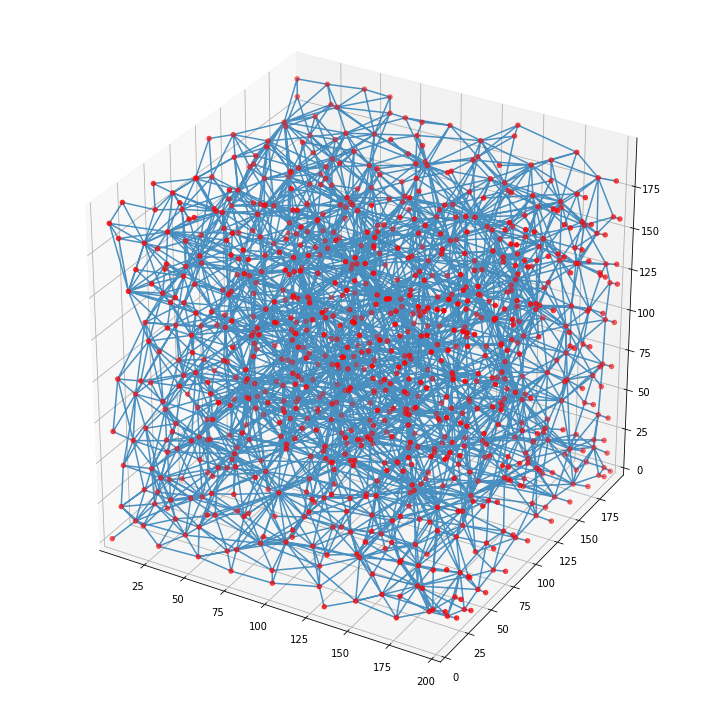

In [5]:
fig = op.topotools.plot_connections(network=net, alpha=0.8)
fig = op.topotools.plot_coordinates(network=net, fig=fig, color='r')
fig.set_size_inches(10, 10)
fig.tight_layout()

In [6]:
geo = op.geometry.Imported(net)

In [7]:
m = sp.meshgrid(range(50, 100, 10), range(50, 100, 10))
m = sp.vstack([-10*sp.ones_like(m[1].flatten()), m[0].flatten(), m[1].flatten()]).T
op.topotools.find_surface_pores(network=net, markers=m, label='left')
op.topotools.clone_pores(network=net, pores=net.pores('left'), labels='left_boundary')
net['pore.coords'][net.pores('left_boundary')] *= [0, 1, 1]

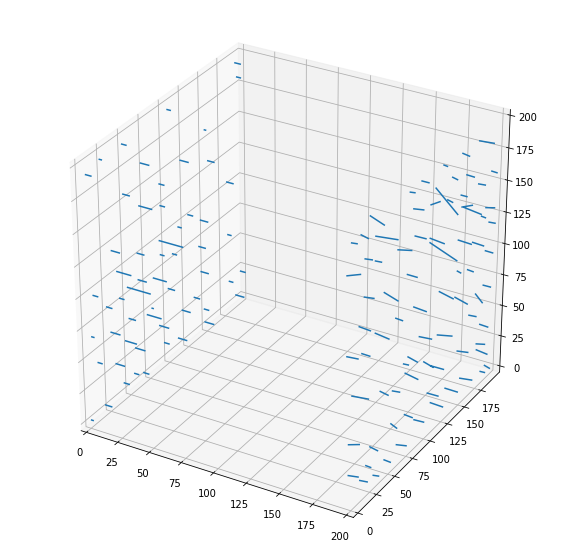

In [8]:
Ps = net.pores('boundary')
net['pore.right_boundary'] = False
net['pore.right_boundary'][Ps] = True
Ts = net.find_neighbor_throats(pores=net.pores('right_boundary'))
net['throat.right_boundary'] = False
net['throat.right_boundary'][Ts] = True
fig = op.topotools.plot_connections(network=net, throats=net.throats(['left_boundary', 'right_boundary']))
fig.set_size_inches(10, 10)

In [9]:
proj = net.project
for geo in proj.geometries().values():
    proj.purge_object(geo)

In [10]:
Ps = net.pores('left_boundary')
Ts = net.find_neighbor_throats(pores=Ps)
geo_bnd = op.geometry.StickAndBall(network=net, pores=Ps, throats=Ts)

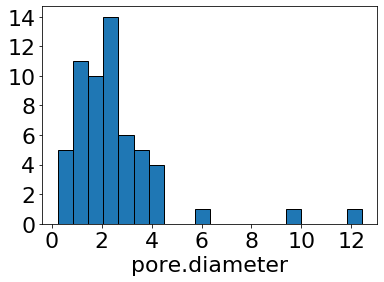

In [11]:
geo_bnd.show_hist('pore.diameter')